In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

url = r'https://data.nsw.gov.au/data/dataset/aefcde60-3b0c-4bc0-9af1-6fe652944ec2/resource/21304414-1ff1-4243-a5d2-f52778048b29/download/confirmed_cases_table1_location.csv'
data = pd.read_csv(url)

#rename some columns, and get relevant columns into dataframe
data = data.rename(columns={"notification_date":"date","lga_name19":"lga","lhd_2010_name":"district"})
data = data[["date","postcode","lga","district"]]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885 entries, 0 to 4884
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      4885 non-null   object 
 1   postcode  4383 non-null   float64
 2   lga       4374 non-null   object 
 3   district  4374 non-null   object 
dtypes: float64(1), object(3)
memory usage: 152.8+ KB


In [2]:
data.describe()

,postcode
count,4383.000000
mean,2254.178645
std,232.003223
min,1871.000000
25%,2089.000000
50%,2166.000000
75%,2336.500000
max,2880.000000


In [3]:
#Some data has NaN value as the location some covid-19 cases is untraceable
#Postcode is float type atm, change to text
data["postcode"] = data["postcode"].fillna(9999)
data["lga"] = data["lga"].fillna("Unknown")
data["district"] = data["district"].fillna("Unknown")
data["postcode"]= data["postcode"].astype(object)
data["date"]= pd.to_datetime(data["date"])
data

,date,postcode,lga,district
0,2020-01-25,2134,Burwood (A),Sydney
1,2020-01-25,2121,Parramatta (C),Northern Sydney
2,2020-01-25,2071,Ku-ring-gai (A),Northern Sydney
3,2020-01-27,2033,Randwick (C),South Eastern Sydney
4,2020-03-01,2163,Fairfield (C),South Western Sydney
...,...,...,...,...
4880,2021-01-16,2088,Mosman (A),Northern Sydney
4881,2021-01-16,2144,Cumberland (A),Western Sydney
4882,2021-01-16,2144,Cumberland (A),Western Sydney
4883,2021-01-16,9999,Unknown,Unknown


In [4]:
#create date type columns
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
data["weekday"] = data["date"].dt.weekday
data["dayofweek"] = data["date"].dt.day_name()

data

,date,postcode,lga,district,day,month,year,weekday,dayofweek
0,2020-01-25,2134,Burwood (A),Sydney,25,1,2020,5,Saturday
1,2020-01-25,2121,Parramatta (C),Northern Sydney,25,1,2020,5,Saturday
2,2020-01-25,2071,Ku-ring-gai (A),Northern Sydney,25,1,2020,5,Saturday
3,2020-01-27,2033,Randwick (C),South Eastern Sydney,27,1,2020,0,Monday
4,2020-03-01,2163,Fairfield (C),South Western Sydney,1,3,2020,6,Sunday
...,...,...,...,...,...,...,...,...,...
4880,2021-01-16,2088,Mosman (A),Northern Sydney,16,1,2021,5,Saturday
4881,2021-01-16,2144,Cumberland (A),Western Sydney,16,1,2021,5,Saturday
4882,2021-01-16,2144,Cumberland (A),Western Sydney,16,1,2021,5,Saturday
4883,2021-01-16,9999,Unknown,Unknown,16,1,2021,5,Saturday


# ================== EDA ==================

# EDA with date

In [5]:
#get a new dataset with date only
columns = ["date","day","month","year","dayofweek","weekday"]
datedata = data.loc[:,columns]

#create new dataset with cases and cumulative count
dailycases= datedata.groupby(["date","day","month","year","dayofweek","weekday"])["date"].count().reset_index(name="cases")
dailycases["culmulative"] = dailycases["cases"].cumsum()

dailycases

,date,day,month,year,dayofweek,weekday,cases,culmulative
0,2020-01-25,25,1,2020,Saturday,5,3,3
1,2020-01-27,27,1,2020,Monday,0,1,4
2,2020-03-01,1,3,2020,Sunday,6,2,6
3,2020-03-02,2,3,2020,Monday,0,3,9
4,2020-03-03,3,3,2020,Tuesday,1,6,15
...,...,...,...,...,...,...,...,...
308,2021-01-13,13,1,2021,Wednesday,2,2,4854
309,2021-01-14,14,1,2021,Thursday,3,2,4856
310,2021-01-15,15,1,2021,Friday,4,14,4870
311,2021-01-16,16,1,2021,Saturday,5,14,4884


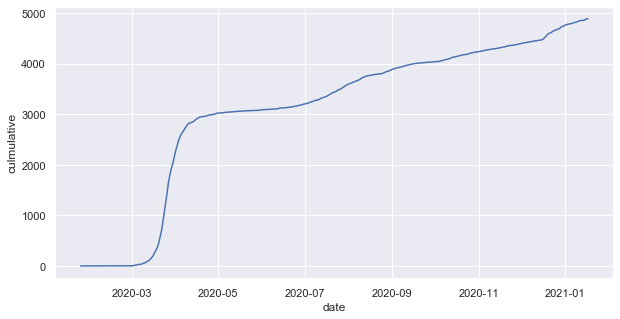

In [6]:
#Plot to see cumululative cases
sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(x=dailycases["date"],y=dailycases["culmulative"])

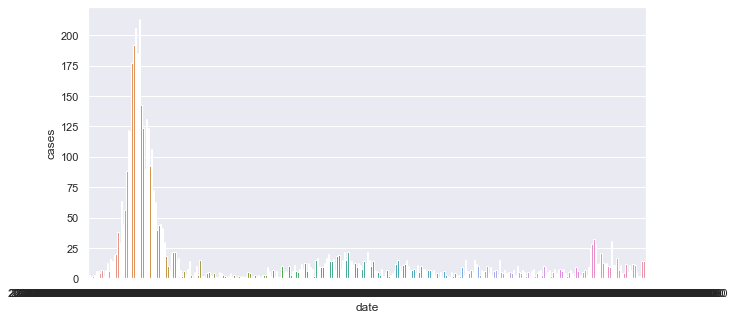

In [7]:
#Plot into barchart
sns.barplot(x=dailycases["date"],y=dailycases["cases"])
plt.show()

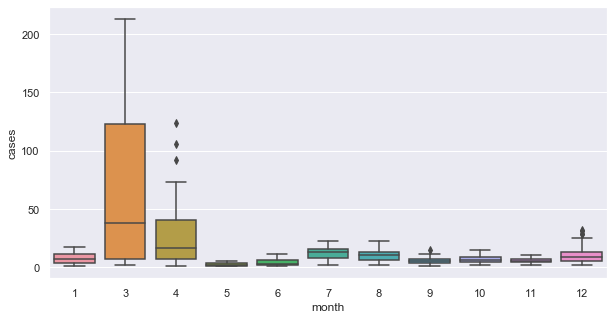

In [8]:
#plot into boxplot using month column to see distribution of data
sns.boxplot(x=dailycases["month"],y=dailycases["cases"])
plt.show()

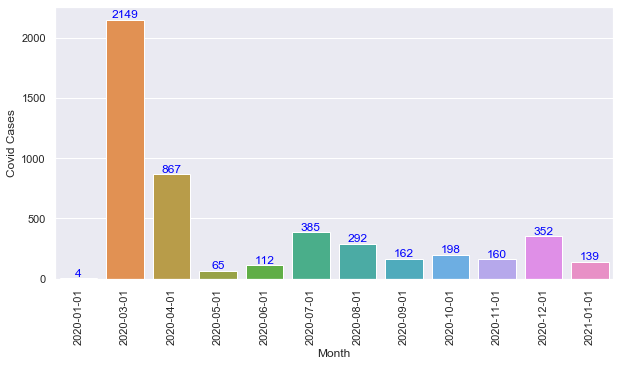

In [22]:
#create new dataset for monthly cases figure
monthlycases = dailycases.loc[:,["cases","month","year"]]
monthlycases = monthlycases.groupby(["month","year"])["cases"].sum().reset_index(name="cases")
monthlycases["date"]=pd.to_datetime(monthlycases[["year","month"]].assign(DAY=1)).dt.date
monthlycases = monthlycases.drop(columns = {"month","year"})
monthlycases.sort_values(by=["date"], inplace = True)

#monthly cases bar chart
chrt = sns.barplot(x=monthlycases["date"], y=monthlycases["cases"])
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =12)

chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="Month",ylabel= "Covid Cases")
chrt.set_xticklabels(chrt.get_xticklabels(), rotation = 90)
plt.show()

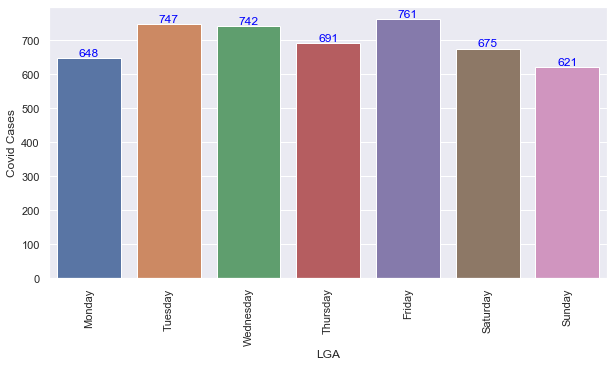

In [10]:
#new dataset for covid cases by the day of a week
weekdaycases = dailycases.loc[:,["cases","dayofweek","weekday"]]
weekdaycases = weekdaycases.groupby(["dayofweek","weekday"])["cases"].sum().reset_index(name="cases")
weekdaycases = weekdaycases.sort_values(by=["weekday"])

#plot to see which day has most cases
chrt = sns.barplot(x=weekdaycases["dayofweek"], y=weekdaycases["cases"])
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =12)

chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="LGA",ylabel= "Covid Cases")
chrt.set_xticklabels(chrt.get_xticklabels(), rotation = 90)
plt.show()

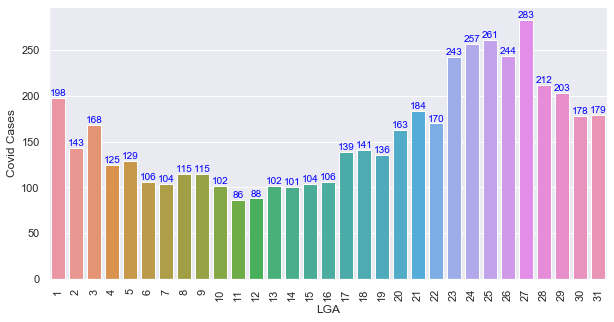

In [11]:
#dataset for cases by day of a month
daycases = dailycases.loc[:,["day","cases"]]
daycases = daycases.groupby(["day"])["cases"].sum().reset_index(name="cases")

#plot to see which day has most cases
chrt = sns.barplot(x=daycases["day"], y=daycases["cases"])
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =10)

chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="LGA",ylabel= "Covid Cases")
plt.show()

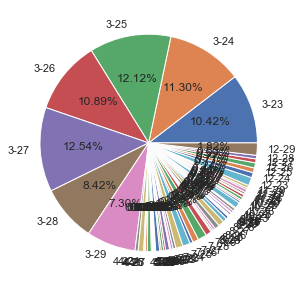

In [12]:
#create dataset that has day range from 23 to 28, data start from march
conditions = (dailycases["day"]>=23)&(dailycases["day"]<=29)&(dailycases["year"]==2020)&(dailycases["month"]>=3)
eomdata = dailycases.loc[conditions]

eomdata = eomdata.drop(columns={"year","dayofweek","culmulative","date"})
eomdata["cat"]= eomdata["month"].astype(str)+"-"+eomdata["day"].astype(str)

plt.pie(x=eomdata["cases"], labels=eomdata["cat"], autopct="%.2f%%")
plt.show()

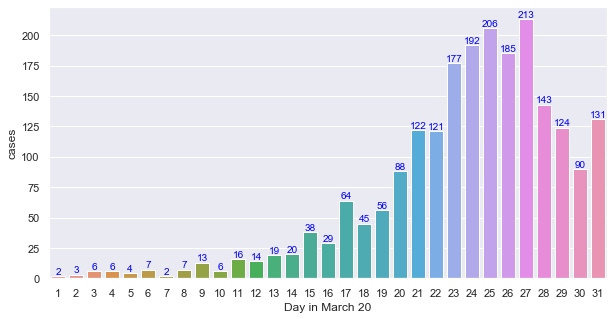

In [13]:
#I want to see the distribution of march data
marchdata = dailycases.loc[(dailycases["month"]==3)]

chrt = sns.barplot(x=marchdata["day"], y=marchdata["cases"])
chrt.set(xlabel="Day in March 20")
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =10)
plt.show()

# EDA with LGA

In [14]:
#Group data by lga
lga = data.groupby(["lga"])["lga"].count().reset_index(name="count")
lga = lga.sort_values(by=["count"], ascending= False)

#no need for unknown data
lgadata = lga[lga["lga"]!="Unknown"]
lgadata

,lga,count
66,Northern Beaches (A),290
97,Waverley (A),224
25,Cumberland (A),217
84,Sydney (C),214
8,Blacktown (C),208
...,...,...
44,Junee (A),1
63,Narromine (A),1
62,Narrandera (A),1
60,Muswellbrook (A),1


[]

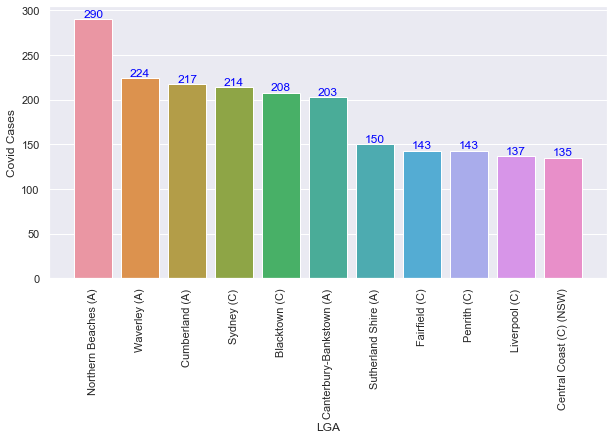

In [15]:
#get top 10 lga that has most cases and not include unknown
top10lga = lgadata.iloc[:11]
chrt = sns.barplot(x=top10lga["lga"], y=top10lga["count"])

for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =12)

chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="LGA",ylabel= "Covid Cases")

chrt.plot()

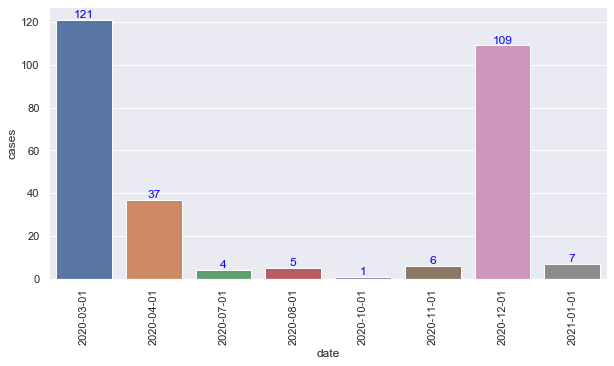

In [16]:
#Monthly cases for Northern Beaches LGA
northern = data.loc[data["lga"]=="Northern Beaches (A)"]
northern = northern.loc[:,["month","year"]]

northern = northern.groupby(["month","year"])["month"].count().reset_index(name="cases")
northern["date"] = pd.to_datetime(northern[["year","month"]].assign(DAY=1)).dt.date
northern.sort_values(by=["date"], inplace = True)

#Plot inside bar chart
chrt = sns.barplot(x=northern["date"], y=northern["cases"])
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =12)
chrt.set_xticklabels(chrt.get_xticklabels(), rotation = 90)
plt.show()

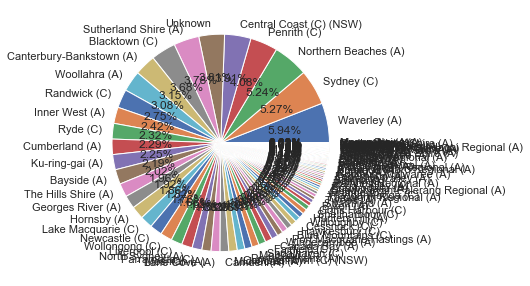

In [17]:
#Proportion of LGA based on Mar and Apr 2020 outbreak
marapr = data.loc[(data["month"]==3)|(data["month"]==4)& (data["year"]==2020)]
marapr = marapr.groupby(["lga"])["lga"].count().reset_index(name="cases")
marapr.sort_values(by=["cases"], inplace=True, ascending = False)
#marapr = marapr.iloc[:10,]

plt.pie(x=marapr["cases"], labels=marapr["lga"], autopct="%.2f%%")
plt.show()

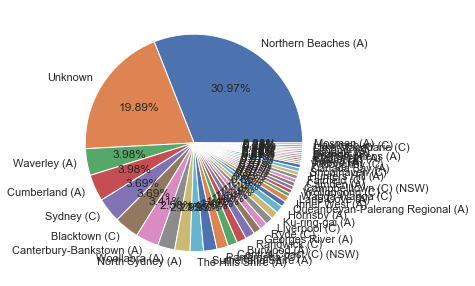

In [18]:
#Proportion of LGA based on Dec 2020.
dec = data.loc[(data["month"]==12) & (data["year"]==2020)]
dec = dec.groupby(["lga"])["lga"].count().reset_index(name="cases")
dec.sort_values(by=["cases"], inplace=True, ascending = False)
#dec = dec.iloc[:10,]

plt.pie(x=dec["cases"], labels=dec["lga"], autopct="%.2f%%")
plt.show()

# EDA for District

In [19]:
#Group data by district
district = data.groupby(["district"])["district"].count().reset_index(name="count")
district = district.sort_values(by=["count"],ascending = False)

#no need for unknown location
district = district[district["district"] != "Unknown"]
district

,district,count
10,South Eastern Sydney,869
9,Northern Sydney,769
16,Western Sydney,628
11,South Western Sydney,602
13,Sydney,391
2,Hunter New England,313
6,Nepean Blue Mountains,212
3,Illawarra Shoalhaven,148
0,Central Coast,135
12,Southern NSW,76


[]

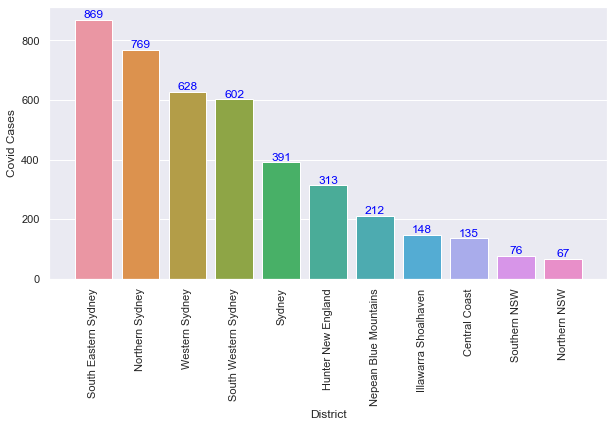

In [20]:
#get top 10 district that has most covid19 cases
top10dis = district.iloc[:11]
chrt = sns.barplot(x=top10dis["district"], y=top10dis["count"])
for p in chrt.patches:
    chrt.annotate("{:.0f}".format(p.get_height()),
                  (p.get_x()+0.4, p.get_height()),
                  ha="center", va="bottom", color="blue", size =12)
chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="District",ylabel= "Covid Cases")

chrt.plot()

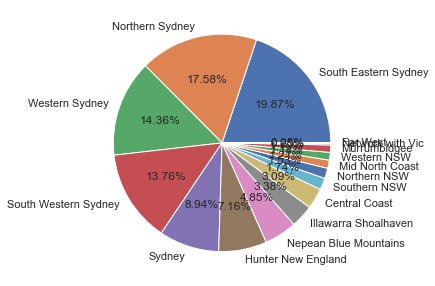

In [21]:
#get pie chart for distribution by district
plt.pie(x=district["count"], labels=district["district"], autopct="%.2f%%")
plt.show()